In [3]:
from __future__ import print_function
import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models

import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import skimage.io as io
import pickle as pk
import copy

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
dataset_root_dir = '/datasets/COCO-2015/'

In [88]:
class CoCoDataset(td.Dataset):
    def __init__(self, root_dir, mode="train2014", image_size=(224, 224)):
        super(CoCoDataset, self).__init__()
        self.image_size = image_size
        self.mode = mode
        self.images_dir = os.path.join(root_dir, "%s/*.jpg" % mode)
        self.style = Image.open('picasso.jpg').convert('RGB')
        if os.path.exists('%s_imgs.pkl' % mode):
            with open('%s_imgs.pkl' % mode, 'rb') as file:
                self.imgs = pk.load(file)
        else:
            self.imgs = io.ImageCollection(self.images_dir)
        self.imgs = self.imgs[:32]
    def __len__(self):
        return len(self.imgs)
    def __repr__(self):
        return "CoCoDataset(mode={}, image_size={})". \
            format(self.mode, self.image_size)
    def __getitem__(self, idx):
        #img = np.moveaxis(self.imgs[idx], [0,1,2], [1,2,0])
        img = Image.fromarray(self.imgs[idx])
        transform = tv.transforms.Compose([
        tv.transforms.Resize(self.image_size),
        #tv.transforms.RandomCrop(self.image_size),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
        ])
        x = transform(img)
        d = transform(self.style)
        return x, d

In [7]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [89]:
train_set = CoCoDataset(dataset_root_dir)
train_loader = td.DataLoader(train_set, batch_size=16, shuffle=True, pin_memory=True)

In [90]:
len(train_set)

32

In [91]:
len(train_loader)

2

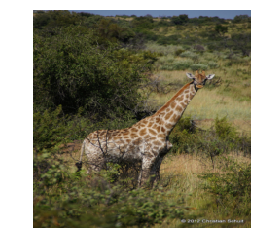

In [12]:
x, y = train_set.__getitem__(100)
myimshow(x)

In [13]:
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [14]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [15]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [50]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [68]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [18]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [19]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.Adam([input_img.requires_grad_()], lr=1)
    return optimizer

In [85]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_imgs, num_steps=500,
                       style_weight=1000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    print('Optimizing..')
    for input_img, d in input_imgs:
        input_img, d = input_img.to(device), d.to(device)
        content_img = copy.deepcopy(input_img)
        model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, d, content_img)
        optimizer = get_input_optimizer(input_img)
        run = [0]
        while run[0] <= num_steps:
            def closure():
            # correct the values of updated input image
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()
                model(input_img)
                style_score = 0
                content_score = 0

                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss

                style_score *= style_weight
                content_score *= content_weight

                loss = style_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()))
                    print()

                return style_score + content_score

            optimizer.step(closure)

    # a last correction...
        input_img.data.clamp_(0, 1)
    return input_imgs

In [58]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=500,
                       style_weight=1000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)
    return input_img

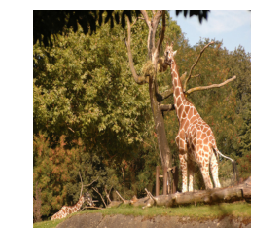

In [78]:
content_img, style_img = train_set[1]
myimshow(content_img.detach())

In [92]:
train_loader = td.DataLoader(train_set, batch_size=16, shuffle=True, pin_memory=True)
input_imgs = copy.deepcopy(train_loader)
#style_img = style_img.unsqueeze(0).cuda()

In [93]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            train_loader, style_img, input_imgs)

Building the style transfer model..
Optimizing..


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 2.140326 Content Loss: 28.658806

run [100]:
Style Loss : 2.210861 Content Loss: 30.843634

run [150]:
Style Loss : 2.274856 Content Loss: 32.831154

run [200]:
Style Loss : 2.318016 Content Loss: 33.954742

run [250]:
Style Loss : 2.347856 Content Loss: 34.827972

run [300]:
Style Loss : 2.367245 Content Loss: 35.312222

run [350]:
Style Loss : 2.375972 Content Loss: 35.541908

run [400]:
Style Loss : 2.391067 Content Loss: 35.956921

run [450]:
Style Loss : 2.397362 Content Loss: 36.165554

run [500]:
Style Loss : 2.399929 Content Loss: 36.124996



RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 3 and 1 in dimension 1 at /opt/conda/conda-bld/pytorch_1544174967633/work/aten/src/TH/generic/THTensorMoreMath.cpp:1333

In [94]:
output

NameError: name 'output' is not defined

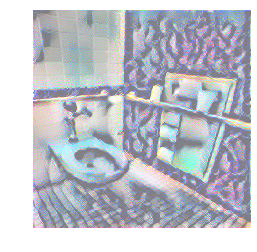

In [47]:
myimshow(output[0].detach())

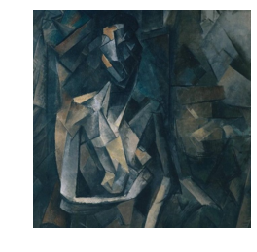

In [48]:
myimshow(style_img[0])

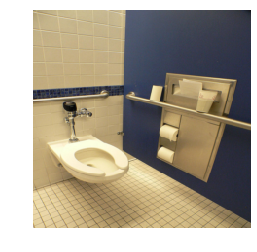

In [49]:
myimshow(content_img[0].detach())

NameError: name 'model' is not defined